# Default training Parameters:

In [1]:
from RLTrain import Opt
import os
import time
print(Opt())

policy                        			MlpPolicy
algorithm                     			PPO
environment                   			WurtzReact-v1
steps                         			500
dir                           			<DEFAULT>
seed                          			None



# Training an agent with default parameters

In [2]:
t=time.time()
os.system("python RLTrain.py steps=200000")
print(time.time()-t)

5282.59273648262


# Running inference with the trained models and saving [S,A,R,S] info

In [3]:
os.system("python RLTest.py PPO_WurtzReact-v1 steps=500")
os.system("python RLTest.py WRH algorithm=WRH steps=500")

0

# Gathering some Heuristics

In [1]:
import pandas as pd
ppo = pd.read_pickle("PPO_WurtzReact-v1/rollout")
heuristic = pd.read_pickle("WRH/rollout")

print(ppo.keys())

info = [
    ['dT', 'dV', '1-chlorohexane', '2-chlorohexane', '3-chlorohexane', 'Na' ],
    ('PPO', [
        [a for a in ppo.Action.mean()],
        [ppo[ppo.Done==True].Reward.mean()]*6,
        [1,0,0,0,0,0]]),
    ('Heuristic', [
        [a for a in heuristic.Action.mean()],
        [heuristic[heuristic.Done==True].Reward.mean()]*6,
        [1,0,0,0,0,0]]),

]

Index(['InState', 'Action', 'Reward', 'OutState', 'Done', 'Info', 'Step'], dtype='object')


In [2]:
print(heuristic[heuristic.Done==True].Reward.mean())

print(ppo[ppo.Done==True].Reward.mean())

0.30924475341993485
0.3080756079493899


# Plot as a Radar Graph

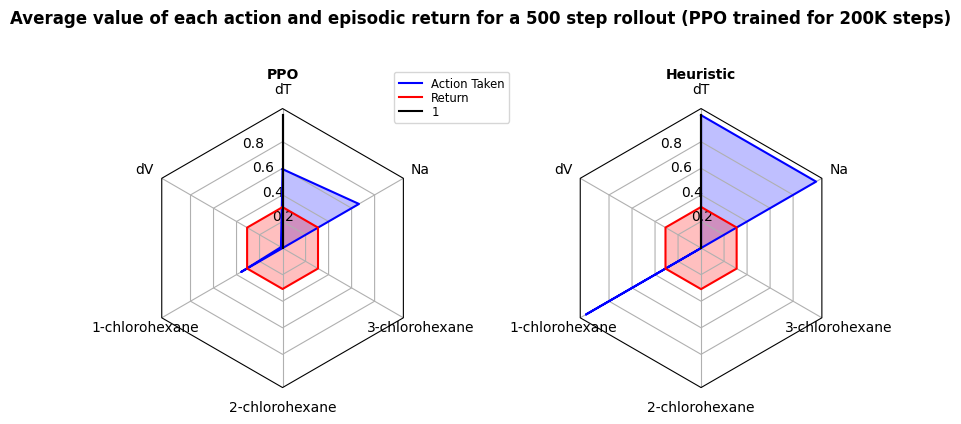

In [3]:
from RadarGraph import *


theta = radar_factory(len(info[0]), frame='polygon')


fig, axs = plt.subplots(figsize=(9, 9), nrows=1, ncols=2,subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.5, hspace=0.25, top=0.85, bottom=0.05)

make_radar(theta,axs,info,colors = "brk")

labels = ('Action Taken', 'Return', '1', 'Factor 4', 'Factor 5')
legend = axs[0].legend(labels, loc=(0.9, .95),labelspacing=0.1, fontsize='small')


fig.text(0.5, 0.7, "Average value of each action and episodic return for a 500 step rollout (PPO trained for 200K steps)",
             horizontalalignment='center', color='black', weight='bold',
             size='large')

plt.show()

# Getting Entire Wurtz Family Trained

In [1]:
import os
os.system("python RLTrain.py environment=GenWurtzReact-v1 steps=500000")
os.system("python RLTrain.py environment=GenWurtzExtract-v1 steps=50000")
os.system("python RLTrain.py environment=WurtzDistill-v1 steps=50000")

1

In [72]:
import os
os.system("python RLTest.py PPO_GenWurtzReact-v1 steps=5000")
os.system("python RLTest.py PPO_GenWurtzExtract-v1 steps=500")
os.system("python RLTest.py PPO_WurtzDistill-v1 steps=500")

0

In [85]:
os.system("python RLTest.py GWRH environment=GenWurtzReact-v1 algorithm=WRH steps=5000")

0

In [7]:
gppo = pd.read_pickle("PPO_GenWurtzReact-v1/rollout")
gheuristic = pd.read_pickle("GWRH/rollout")

# Functions for Conditional Returns and Actions

In [51]:
import sys
sys.path.append('../')

from chemistrylab.reactions.available_reactions.chloro_wurtz import PRODUCTS as CWtargs

def get_conditional_rewards(frame,targets=CWtargs):
    """
    Gives returns conditioned on the different targets
    Inputs:
        Frame (dataframe) - Pandas Dataframe containing gym information
        targets (list) - List of N targets (reaction products)
        
    Outputs:
        targets
        rew (List<float>) - List of size N containing the average return given each target
    
    """
    # turn observation column into a numpy array
    obs = np.stack(frame.InState)
    N=len(targets)
    rew=[]
    for i in range(N):
        #gather all data where the target is targets[N]
        cframe=frame[obs[:,-N+i]>0.9]
        #Obtain the mean reward of these episodes
        rew+=[cframe[cframe.Done==True].Reward.mean()]
    return [targets,rew]

def get_conditional_actions(frame,targets=CWtargs):
    """
    Gives actions conditioned on the different targets, meant for continuous action spaces
    Inputs:
        Frame (dataframe) - Pandas Dataframe containing gym information
        targets (list) - List of N targets (reaction products)
        
    Outputs:
        targets
        act (List<array>) - List of size N containing the mean action given each target
    
    """
    # turn observation column into a numpy array
    obs = np.stack(frame.InState)
    N=len(targets)
    act=[]
    for i in range(N):
        #gather all data where the target is targets[N]
        cframe=frame[obs[:,-N+i]>0.9]
        #Obtain the mean action of these episodes
        act+=[cframe.Action.mean()]
    return [targets,act]

# General Wurtz React:

In [103]:
info = [
    get_conditional_rewards(gppo)[0],
    ('PPO', [get_conditional_rewards(gppo)[1]]),
    ('Heuristic', [get_conditional_rewards(gheuristic)[1]]),

]

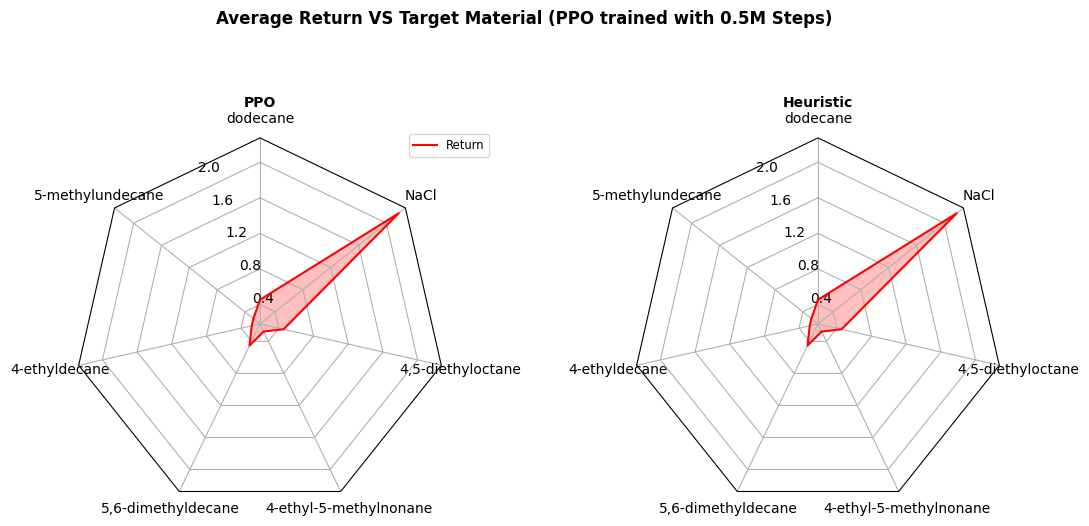

In [104]:
from RadarGraph import *


theta = radar_factory(len(info[0]), frame='polygon')

fig, axs = plt.subplots(figsize=(12, 12), nrows=1, ncols=2,subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.5, hspace=0.25, top=0.85, bottom=0.05)

make_radar(theta,axs,info,colors = "r",gridlines=[0.4,0.8,1.2,1.6,2.0])

labels = ('Return', '-', '1', 'Factor 4', 'Factor 5')
legend = axs[0].legend(labels, loc=(0.9, .95),labelspacing=0.1, fontsize='small')


fig.text(0.5, 0.7, "Average Return VS Target Material (PPO trained with 0.5M Steps)",
             horizontalalignment='center', color='black', weight='bold',
             size='large')

plt.show()

In [132]:
info0 = [
    ['dT', 'dV', '1-chlorohexane', '2-chlorohexane', '3-chlorohexane', 'Na' ],
    ('PPO', [[b for b in act] for act in get_conditional_actions(gppo)[1]]),
    ('Heuristic', [[b for b in act] for act in get_conditional_actions(gheuristic)[1]]),

]

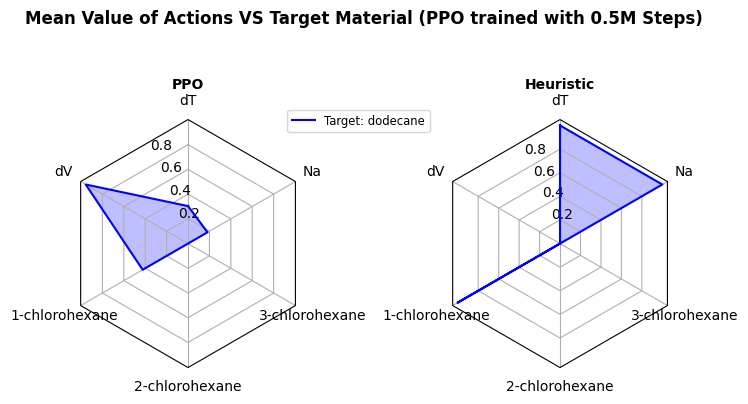

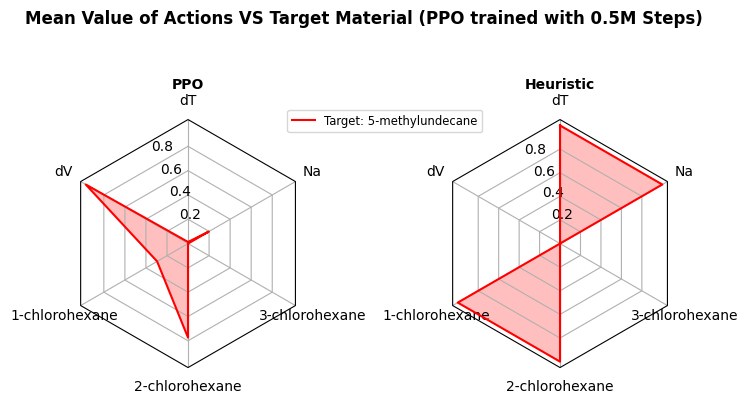

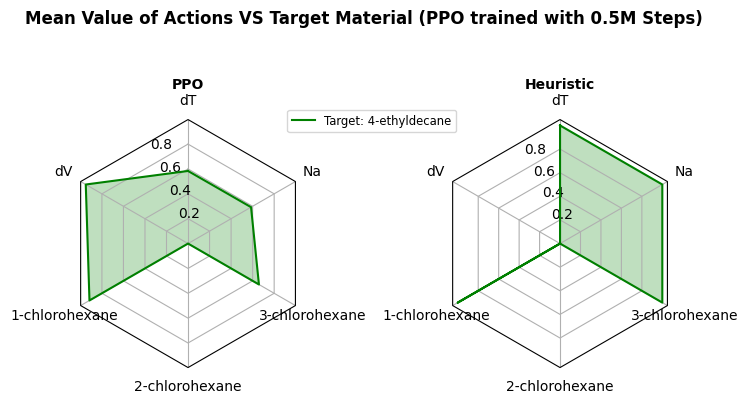

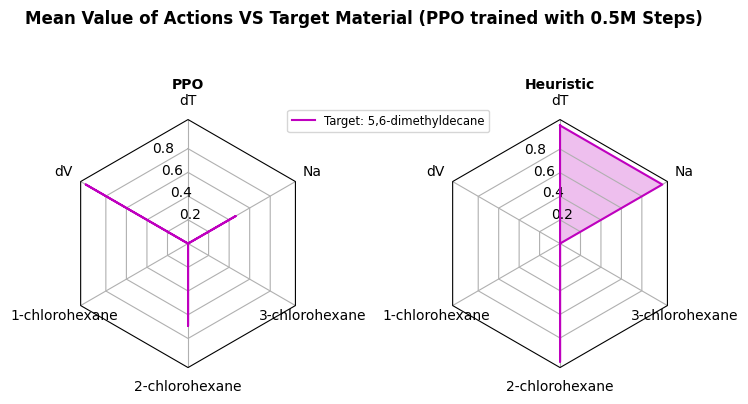

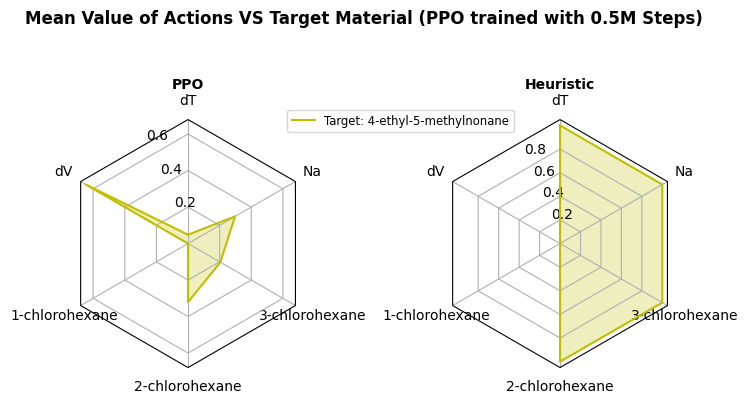

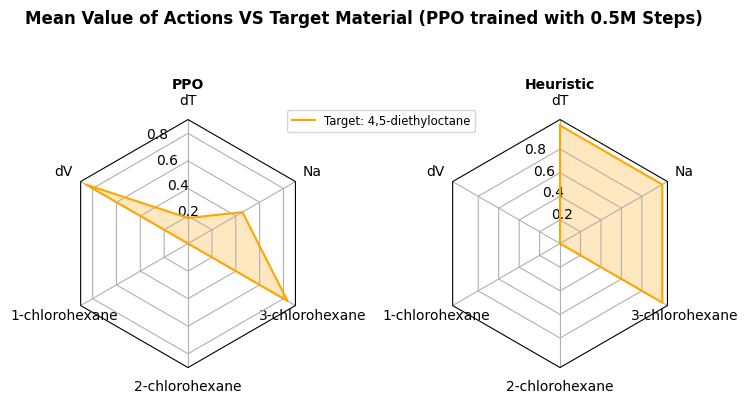

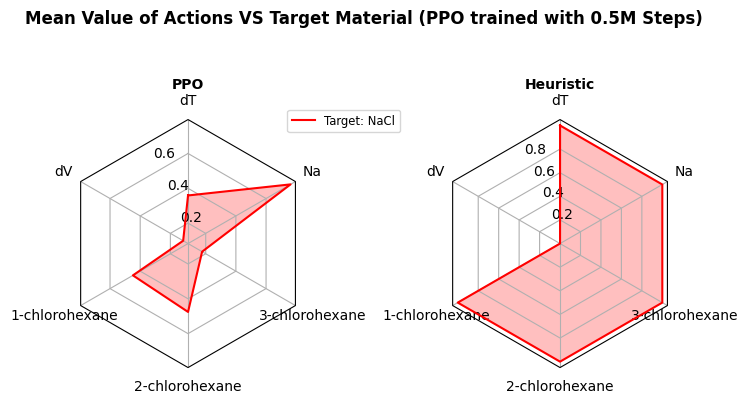

In [134]:
for i in range(len(CWtargs)):
    
    info=[info0[0],(info0[1][0],info0[1][1][i:i+1]),(info0[2][0],info0[2][1][i:i+1])]


    theta = radar_factory(len(info[0]), frame='polygon')
    fig, axs = plt.subplots(figsize=(8, 4), nrows=1, ncols=2,subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.5, hspace=0.25, top=0.85, bottom=0.05)
    c=['b', 'r', 'g', 'm', 'y',"orange","r"][i:i+1]
    make_radar(theta,axs,info,colors=c)
    labels = ["Target: "+CWtargs[i]]
    legend = axs[0].legend(labels, loc=(0.9, .95),labelspacing=0.1, fontsize='small')
    fig.text(0.5, 1.0, "Mean Value of Actions VS Target Material (PPO trained with 0.5M Steps)",
                 horizontalalignment='center', color='black', weight='bold',
                 size='large')
    plt.show()

# Fict React:

Reactions at play:

A+B $\rightarrow$ E</br>
A+D $\rightarrow$ F</br>
B+D $\rightarrow$ G</br>
F+G $\rightarrow$ I</br>

In [73]:
os.system("python RLTest.py PPO_FictReact-v2 steps=5000")

0

In [107]:
os.system("python RLTest.py FR2H environment=FictReact-v2 algorithm=FR2H steps=5000")

0

In [108]:
from chemistrylab.reactions.available_reactions.fict_react2 import PRODUCTS as FRtargs
from chemistrylab.reactions.available_reactions.fict_react2 import REACTANTS as FRchoices
fppo = pd.read_pickle("PPO_FictReact-v2/rollout")

fheuristic = pd.read_pickle("FR2H/rollout")

In [126]:
info = [
    get_conditional_rewards(fppo,FRtargs)[0],
    ('PPO', [get_conditional_rewards(fppo,FRtargs)[1]]),
    ('Heuristic', [get_conditional_rewards(fheuristic,FRtargs)[1]]),
    
]

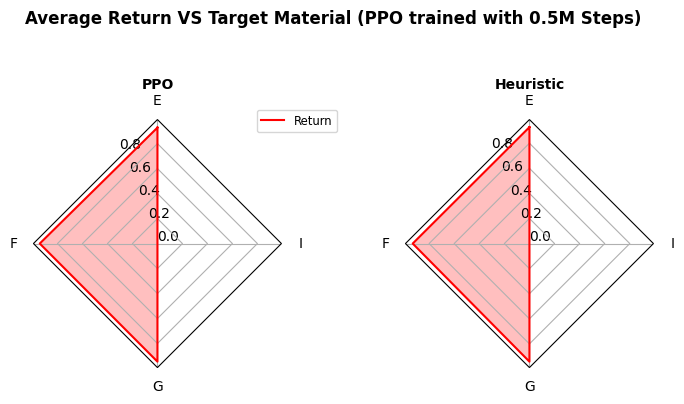

In [127]:
from RadarGraph import *

theta = radar_factory(len(info[0]), frame='polygon')

fig, axs = plt.subplots(figsize=(8, 4), nrows=1, ncols=2,subplot_kw=dict(projection='radar'))

#axs = np.array([axs])

fig.subplots_adjust(wspace=0.5, hspace=0.25, top=0.85, bottom=0.05)

make_radar(theta,axs,info,colors = "r",gridlines=[0.0,0.2,0.4,0.6,0.8])

labels = ('Return', '-', '1', 'Factor 4', 'Factor 5')
legend = axs[0].legend(labels, loc=(0.9, .95),labelspacing=0.1, fontsize='small')


fig.text(0.5, 1.0, "Average Return VS Target Material (PPO trained with 0.5M Steps)",
             horizontalalignment='center', color='black', weight='bold',
             size='large')

plt.show()

In [113]:
info0 = [
    ['dT', 'dV', ]+FRchoices,
    ('PPO', [[b for b in act] for act in get_conditional_actions(fppo,FRtargs)[1]]),
    ('Heuristic', [[b for b in act] for act in get_conditional_actions(fheuristic,FRtargs)[1]]),
]

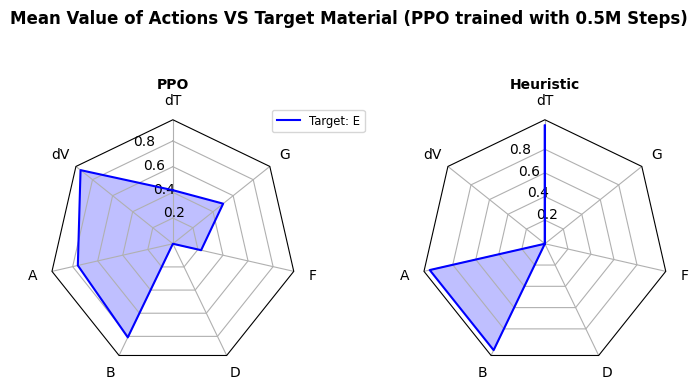

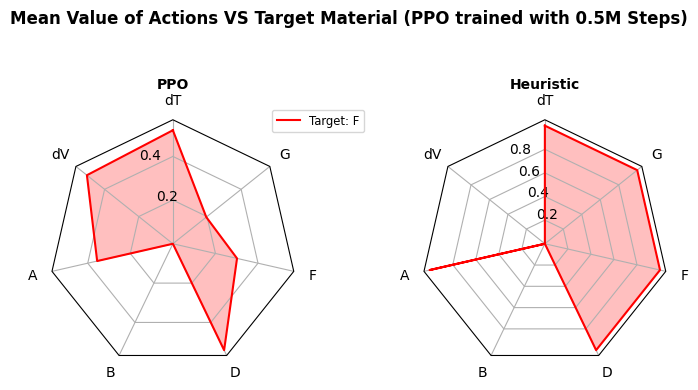

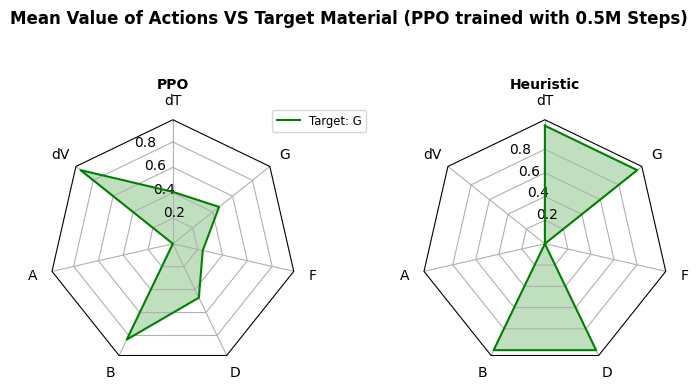

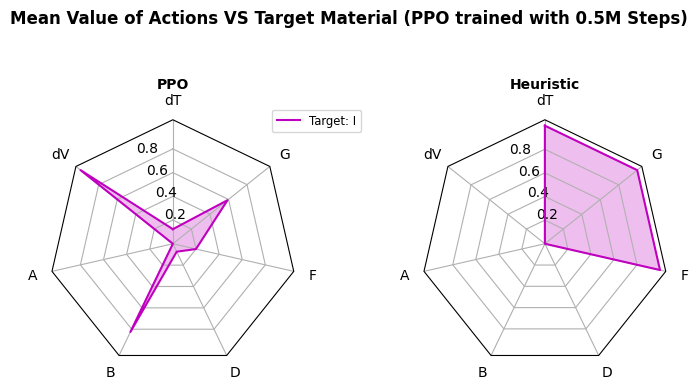

In [128]:
for i in range(len(FRtargs)):
    
    info=[info0[0],(info0[1][0],info0[1][1][i:i+1]),(info0[2][0],info0[2][1][i:i+1])]


    theta = radar_factory(len(info[0]), frame='polygon')
    fig, axs = plt.subplots(figsize=(8, 4), nrows=1, ncols=2,subplot_kw=dict(projection='radar'))
    #axs=np.array([axs])
    fig.subplots_adjust(wspace=0.5, hspace=0.25, top=0.85, bottom=0.05)
    c=['b', 'r', 'g', 'm', 'y',"orange","r"][i:i+1]
    make_radar(theta,axs,info,colors=c)
    labels = ["Target: "+FRtargs[i]]
    legend = axs[0].legend(labels, loc=(0.9, .95),labelspacing=0.1, fontsize='small')
    fig.text(0.5, 1.0, "Mean Value of Actions VS Target Material (PPO trained with 0.5M Steps)",
                 horizontalalignment='center', color='black', weight='bold',
                 size='large')
    plt.show()